<span style="font-size: 23px;"> Linear Regression Model for predicting insurance price<span>

In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.model_selection import train_test_split
import warnings 
from sklearn.linear_model import LinearRegression
import pickle
warnings.filterwarnings("ignore")

<span style="font-size: 18px;">1. Load the data from CSV<span>

In [298]:
data = pd.read_csv('../insurance_data.csv')

<span style="font-size: 18px;">2. Perform the exploratory data analysis<span>

2.1. Showing first 10 rows of the data

In [299]:
data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


2.2. Check the shape i.e. dimension of data

In [300]:
data.shape

(1338, 7)

2.3. 5-point summary (like Median, 25%, 75%, Minimum and Maximum)

In [301]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


2.4. Information about the column (data types)

In [302]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


2.5. Check if any duplicate rows present or now

In [303]:
data.duplicated().sum()

1

2.6. Any missing value

In [304]:
print(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


2.7. Categorical Treatment One hot encoding

In [305]:
data_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)
print(data_encoded.dtypes)
data= data_encoded

age                   int64
bmi                 float64
children              int64
charges             float64
sex_male               bool
smoker_yes             bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object


In [306]:
data.head(10)

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False
5,31,25.740,0,3756.62160,False,False,False,True,False
6,46,33.440,1,8240.58960,False,False,False,True,False
7,37,27.740,3,7281.50560,False,False,True,False,False
8,37,29.830,2,6406.41070,True,False,False,False,False
9,60,25.840,0,28923.13692,False,False,True,False,False


2.8. Correlation between variables

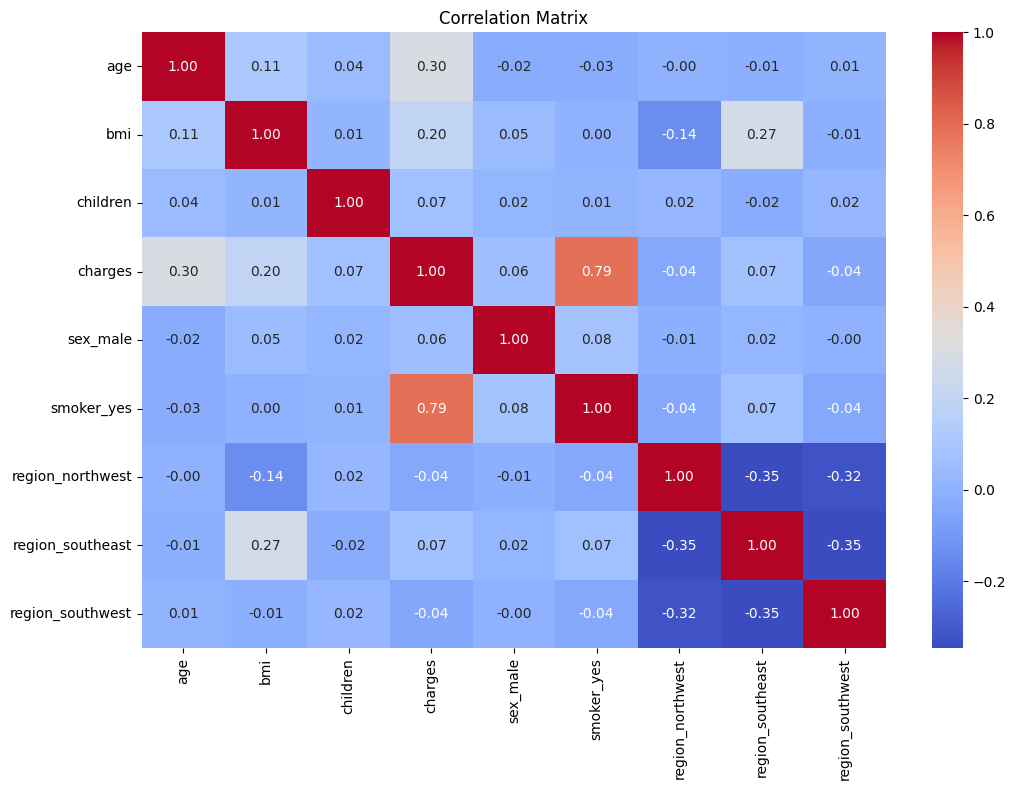

In [307]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

From the data we can see smoke is impacting the charges very much compare to other variable

2.9. Number of outliers

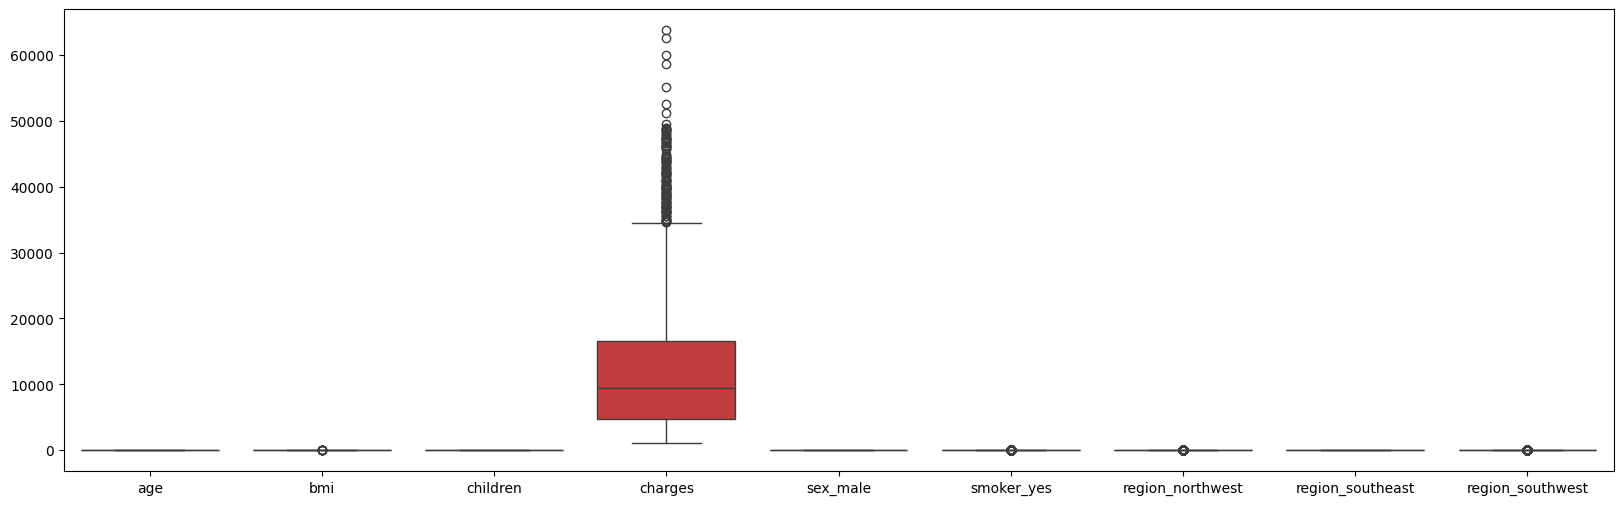

In [308]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=data)
plt.show()

2.10. A set of subplots to visualize the distribution

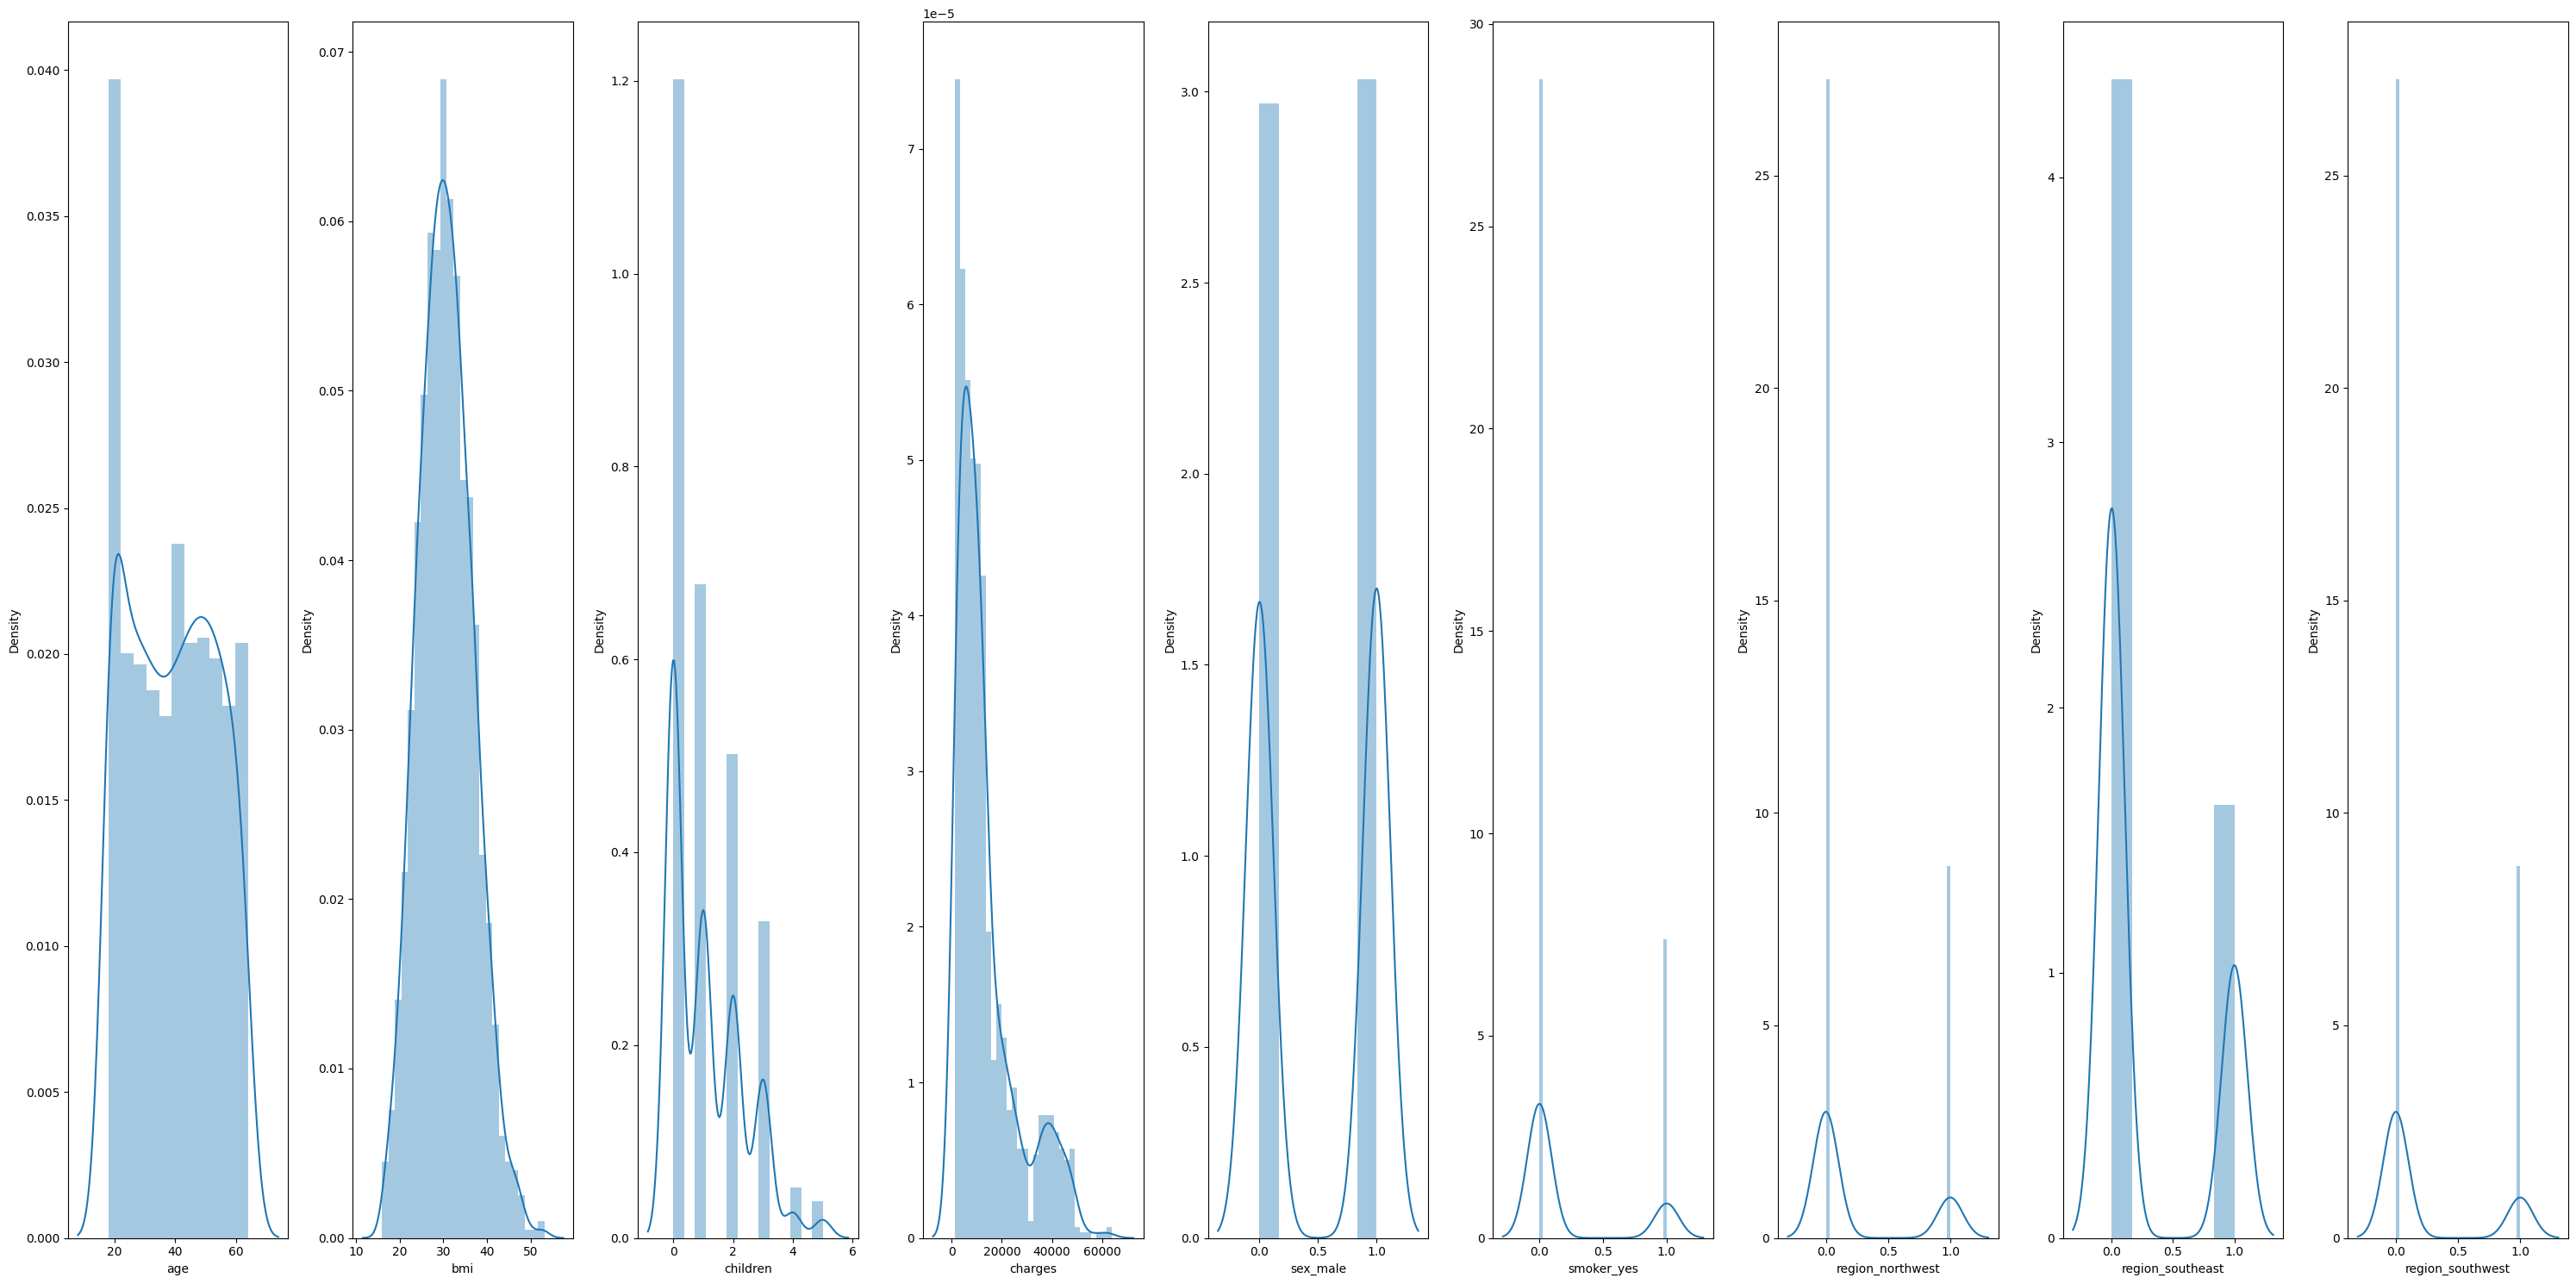

In [309]:
fig, axes = plt.subplots(ncols=len(data.columns), figsize=(30,15))
for ax, col in zip(axes, data.columns):
  sns.distplot(data[col], ax=ax)
  plt.tight_layout() 
plt.show()

2.11. Scatterplots showing relationships between pairs of variables

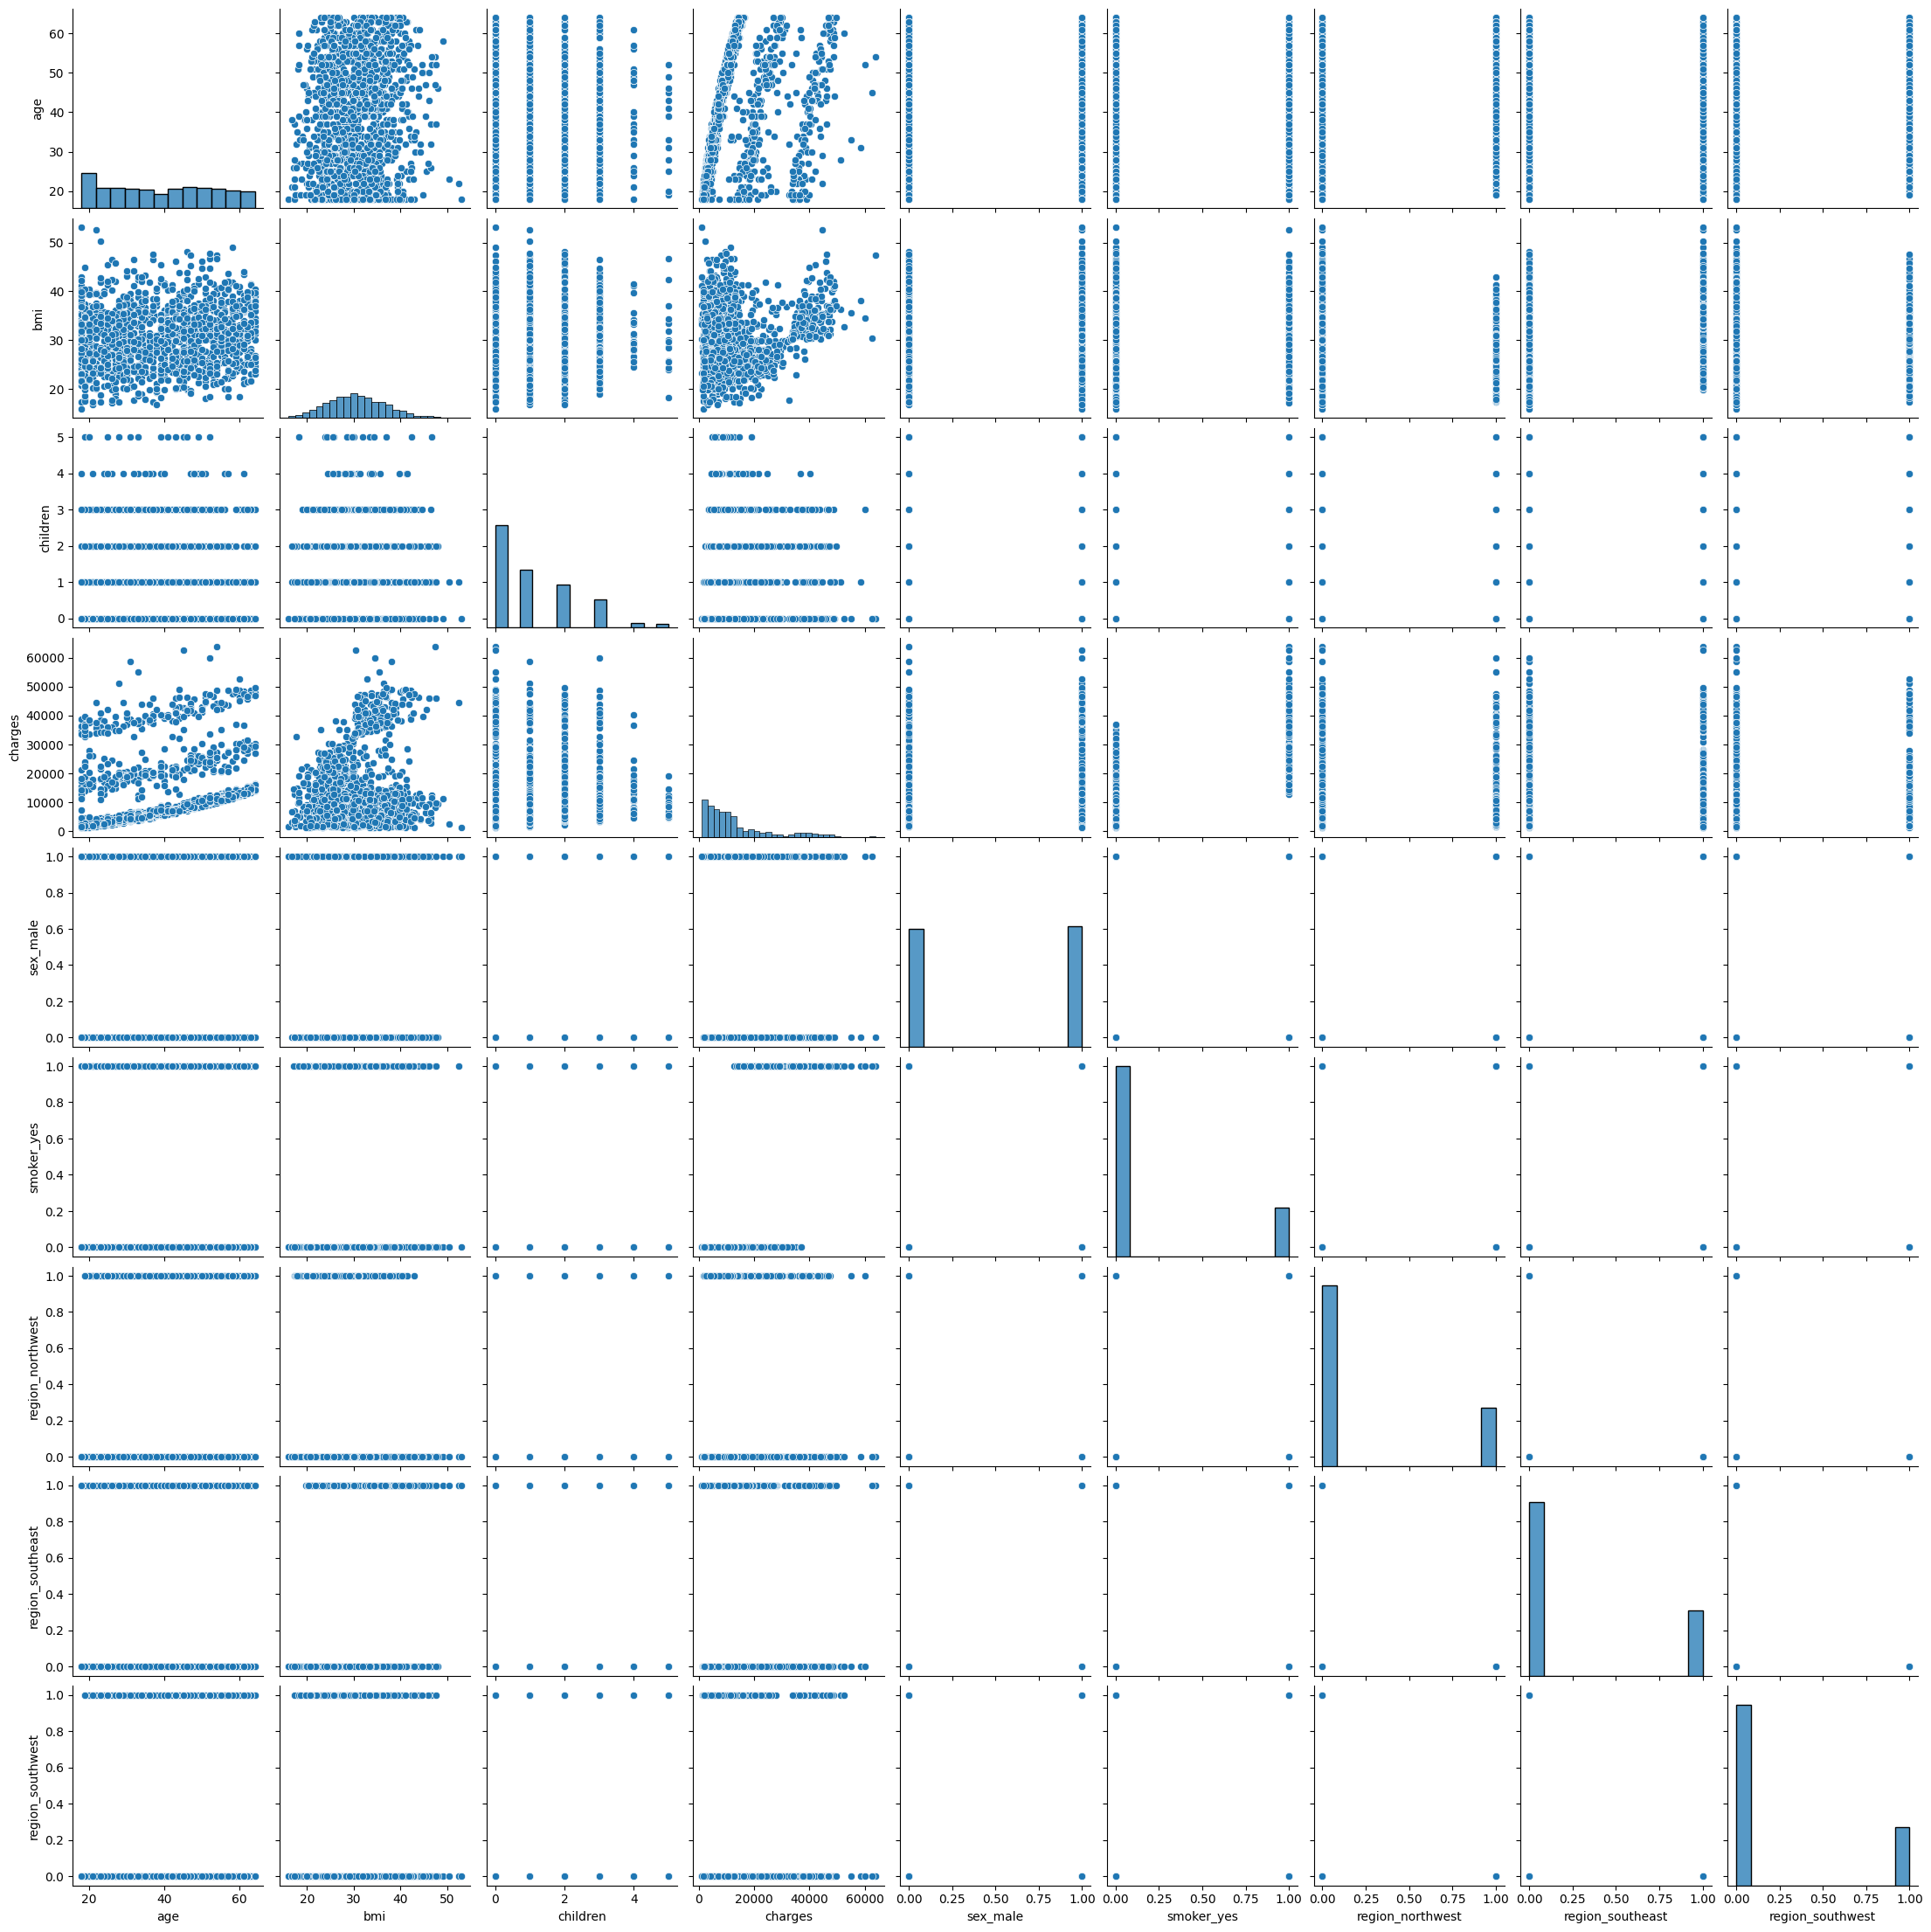

In [310]:
sns.pairplot(data)

2.12. Histogram Plot to see distribution of variables

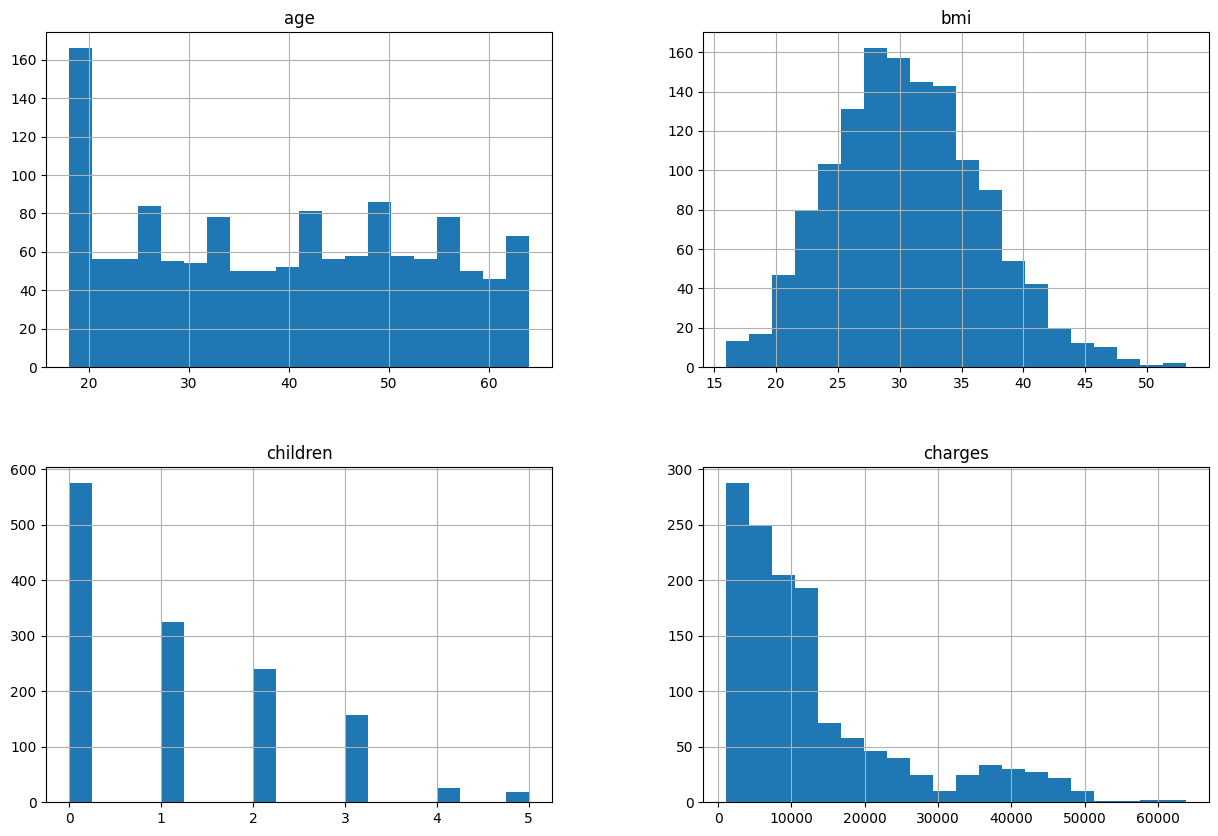

In [311]:
data.hist(figsize=(15, 10), bins=20)
plt.show()

2.13. Check if any missing value or Null value in each column

In [312]:
print(data.isnull().sum())

age                 0
bmi                 0
children            0
charges             0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64


<span style="font-size: 18px;">3. Data Preprocessing<span>

3.1. Removing Duplicate value

In [313]:
data.duplicated().sum()

1

In [314]:
data = data.drop_duplicates()
data.duplicated().sum()

0

3.2. Outlier treatment

3.2.1. Checking the outlier before treatment

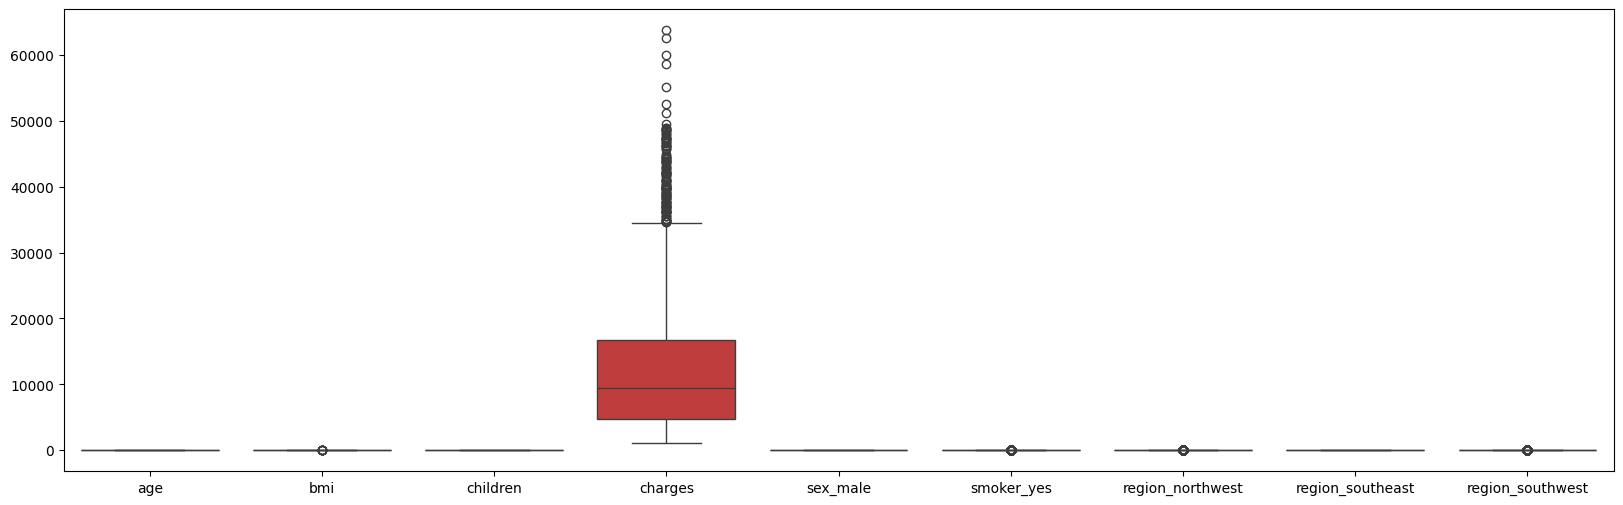

In [315]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=data)
plt.show()

3.2.2. Removing outlier

In [316]:
def outlier_cap(col):
    if np.issubdtype(col.dtype, np.number):  # Check if the column is numeric
        Q1, Q3 = np.percentile(col, [25, 75])
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)
        return lower_range, upper_range
    else:
        return None


In [317]:
for column in data.columns[:-1].tolist():
    lr_ur = outlier_cap(data[column])
    if lr_ur is not None:
        lr, ur = lr_ur
        data[column] = np.where(data[column] > ur, ur, data[column])
        data[column] = np.where(data[column] < lr, lr, data[column])


3.2.3. Showing box plot after removing all outliers

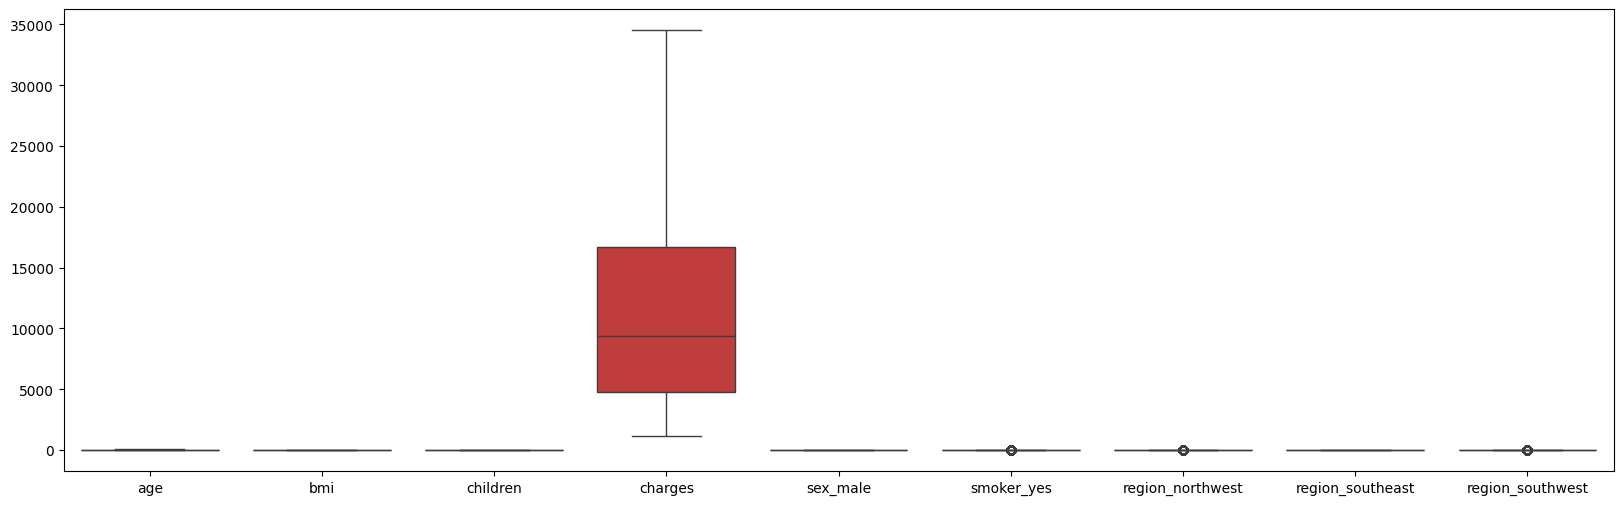

In [318]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=data)
plt.show()

<span style="font-size: 18px;">4. Split the dataset <span>

4.1. Spliting feature and response 

In [319]:
# Putting feature variable to X
X = data.drop('charges',axis=1)

# Putting response variable to y
y = data['charges']

4.2. Split the data into 80% training dataset and 20% test dataset

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=42)
X_train.shape, X_test.shape

((1069, 8), (268, 8))

<span style="font-size: 18px;">5. Model preparation and evaluation<span>

5.1. Train the model with test data

In [321]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

5.2. Co-efficient of liner equation

In [322]:
lr_model.coef_

array([  223.62247052,   217.0895234 ,   462.96932106,  -217.72872648,
       19660.9818596 ,  -246.73250121,  -710.06653609,  -535.87686523])

5.3. Score of the model

In [323]:
lr_model.score(X_train,y_train)

0.7253491753867018

5.4. Predict the trained and test data

5.4.1. Predict Train data

In [324]:
y_pred_train = lr_model.predict(X_train)

In [325]:
RMSE = sqrt(sum((y_pred_train - y_train)**2)/len(y))
RMSE

4680.30153550015

5.4.2. Predict Test data

In [326]:
y_pred_test = lr_model.predict(X_test)

In [327]:
RMSE = sqrt(sum((y_pred_test - y_test)**2)/len(y))
RMSE

2047.0638348901007

In [328]:
X_train.shape

(1069, 8)

In [329]:
y_train.shape

(1069,)

5.5. Linear Regression Plot

5.5.1. Plot for training data set (Considered only smoking flag as it has high impact)

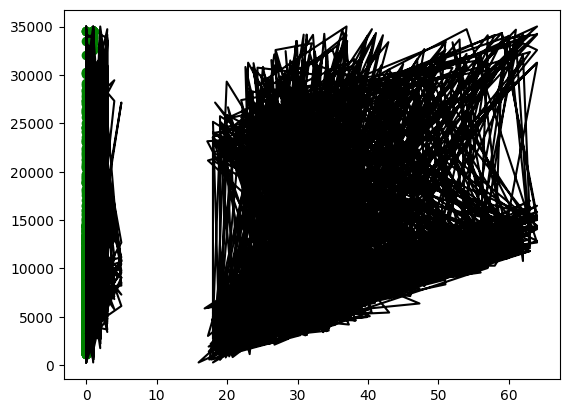

In [330]:
plt.scatter(X_train["smoker_yes"], y_train,color='g')
plt.plot(X_train, y_pred_train,color='k')
plt.show()

5.5.2. Plot for test data set (Considered only smoking flag as it has high impact)

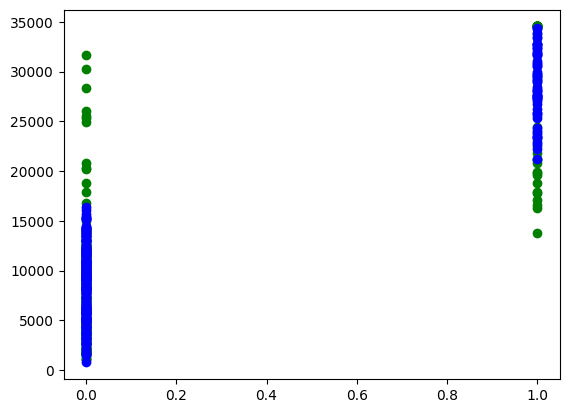

In [331]:
plt.scatter(X_test["smoker_yes"], y_test,color='g')
plt.scatter(X_test["smoker_yes"], y_pred_test,color='b')
plt.show()

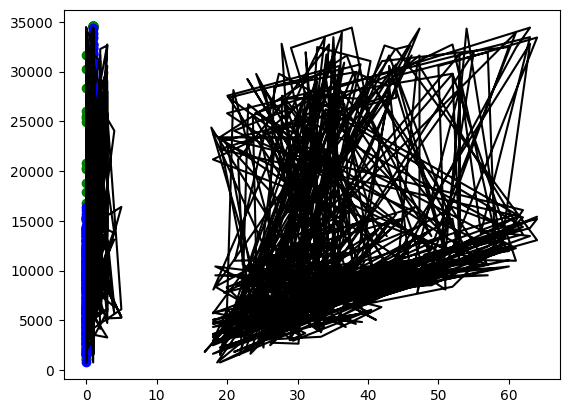

In [332]:
plt.scatter(X_test["smoker_yes"], y_test,color='g')
plt.scatter(X_test["smoker_yes"], y_pred_test,color='b')
plt.plot(X_test, y_pred_test,color='k')
plt.show()

<span style="font-size: 18px;">6. Dumping the final model<span>

In [333]:
with open('linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model,f)

<span style="font-size: 18px;">7. Loading the model to test and predict data<span>

In [334]:
with open("linear_regression_model.pkl",'rb') as f:
    model_pkl = pickle.load(f)

In [335]:
X_test.head(2)

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
900,49.0,22.515,0.0,True,False,False,False,False
1064,29.0,25.600,4.0,False,False,False,False,True


In [336]:
y_test.head(2)

900     8688.85885
1064    5708.86700
Name: charges, dtype: float64

7.1. Predicting one record from data set whose output should be 8688.85885

| age  | bmi   | children | sex_male | smoker_yes | region_northwest | region_southeast | region_southwest |
|------|-------|----------|----------|------------|------------------|------------------|------------------|
| 49.0 | 22.515| 0.0      | True     | False      | False            | False            | False            |


In [357]:
print(model_pkl.predict([[49.0, 22.515,	0.0,True,False	,False	,False	,False]]))

[8642.92522983]


7.2. Predicting one record outside of data set 

| age  | bmi   | children | sex_male | smoker_yes | region_northwest | region_southeast | region_southwest |
|------|-------|----------|----------|------------|------------------|------------------|------------------|
| 26.0 | 20.515| 0.0      | True     | True      | True            | False            | False            |


In [361]:
print(model_pkl.predict([[26.0, 20.515,	0.0,	True,	True	,True	,False	,False]]))

[22479.67871957]


<span style="font-size: 18px;">8. Checking impact of significant and insignificant variable on the model<span>

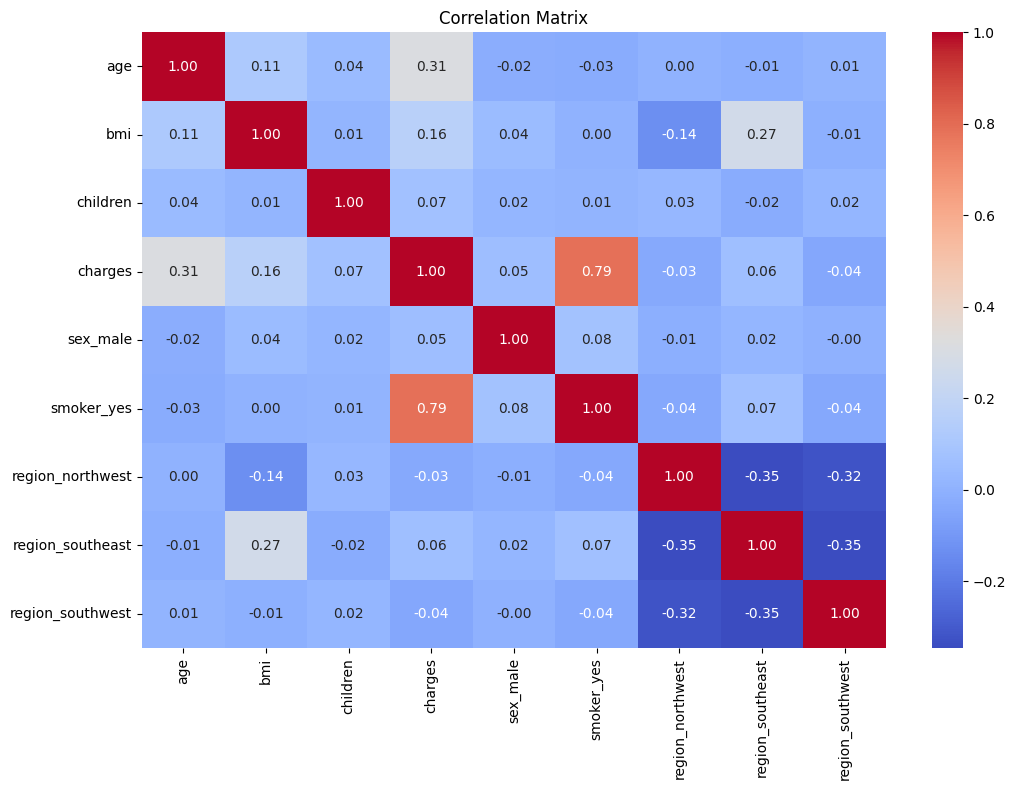

In [339]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Region seems not having any significance So let's remove it

In [340]:
columns_to_drop = ['region_northwest','region_southeast','region_southwest']
processedData = data.drop(columns=columns_to_drop)
processedData.head(5)

,age,bmi,children,charges,sex_male,smoker_yes
0,19.0,27.900,0.0,16884.92400,False,True
1,18.0,33.770,1.0,1725.55230,True,False
2,28.0,33.000,3.0,4449.46200,True,False
3,33.0,22.705,0.0,21984.47061,True,False
4,32.0,28.880,0.0,3866.85520,True,False


In [341]:
# Putting feature variable to X
X_p = processedData.drop('charges',axis=1)

# Putting response variable to y
y_p = processedData['charges']

In [342]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p,y_p,train_size=0.8, random_state=42)
X_train_p.shape, X_test_p.shape

((1069, 5), (268, 5))

In [343]:
lr_model_p = LinearRegression()
lr_model_p.fit(X_train, y_train)

LinearRegression()

In [344]:
lr_model_p.coef_

array([  223.62247052,   217.0895234 ,   462.96932106,  -217.72872648,
       19660.9818596 ,  -246.73250121,  -710.06653609,  -535.87686523])

In [345]:
lr_model.score(X_train,y_train), lr_model_p.score(X_train,y_train)

(0.7253491753867018, 0.7253491753867018)

In [346]:
print(lr_model.predict([[49.0, 22.515,	0.0,	True,	False	,False	,False	,False]]))
print(lr_model_p.predict([[49.0, 22.515,	0.0,	True,	False	,False	,False	,False]]))

[8642.92522983]
[8642.92522983]
